In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import scipy.stats as stats

#sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score

#tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv("../data/cbsa_data_realpageflag.csv")

C:\Users\ahmad\AppData\Local\Temp\ipykernel_38720\636769717.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/cbsa_data_realpageflag.csv")


In [4]:
df.columns

Index(['propertyId', 'propertyName', 'zipCode', 'address', 'city', 'state',
       'averageSquareFootage', 'stories', 'stable', 'class', 'latitude',
       'longitude', 'imageHero', 'heroSource', 'submarketName', 'unitcount',
       'yearBuilt', 'siteStatus', 'type', 'MPF-ANN-RENT-CHG',
       'MPF-HIST-ASK-RENT', 'MPF-HIST-AVG-ASK-RPSF', 'MPF-HIST-CONC-RATIO',
       'MPF-OCC', 'MPF-RENT', 'MPF-RPSF', 'data_index', 'cbsa_code', 'status',
       'SH-HIST-ASK-RENT-PB', 'SH-HIST-RENT-PB', 'SH-HIST-CONC-RATIO-PB',
       'SH-HIST-OCCUPANCY', 'SH-HIST-RPSF-PB', 'SH-HIST-AVG-ASK-RPSF-PB',
       'SH-HIST-ANN-RENT-PB-CHG', 'uses_realpage'],
      dtype='object')

In [5]:
# developing yearsold column (this is just the year the property was built minus the current year)
current_year = datetime.now().year
df['yearsold'] = current_year - df['yearBuilt']

In [6]:
# selecting relevant columns to use in the model
cols = [
    'cbsa_code', 'averageSquareFootage', 'stories', 'class', 'unitcount', 'yearsold', 'MPF-OCC', 'MPF-RPSF', 'uses_realpage'
]
df.dropna(subset=cols,inplace=True)

In [7]:
def print_null_counts(df, columns):
    for col in columns:
        null_count = df[col].isnull().sum()
        print(f"{col}: {null_count} null(s)")


columns_to_check = ['averageSquareFootage', 'stories', 'cbsa_code', 'class', 'yearsold', 'MPF-OCC', 'unitcount','MPF-HIST-CONC-RATIO','uses_realpage','MPF-RPSF']
print_null_counts(df, columns_to_check)

#while the concentration ratio would be phenomenal to use, excluding 25167 rows would be very detrimental to our dataset. this is over 75% of our dataset and would essentially remove most of our cbsa's include ones we have realpage users for

averageSquareFootage: 0 null(s)
stories: 0 null(s)
cbsa_code: 0 null(s)
class: 0 null(s)
yearsold: 0 null(s)
MPF-OCC: 0 null(s)
unitcount: 0 null(s)
MPF-HIST-CONC-RATIO: 27308 null(s)
uses_realpage: 0 null(s)
MPF-RPSF: 0 null(s)


# Feature Engineering & Exploratory Data Analysis (EDA)

Before developing our models, we want to validate parts of our dataset and clean parts that dont make sense. These include the following:

- **Excluding Student Housing:**  
   - **What:** Filter out any properties categorized as student housing.
   - **Why:** Student housing often follows different market dynamics that do not align with our target analysis of RealPage usage and property rent. Removing these properties helps focus our model on the residential segments of interest.

-  **Excluding CBSAs with No RealPage Usage:**  
   - **What:** Remove any Core Based Statistical Areas (CBSAs) that do not have at least one property using RealPage.
   - **Why:** This ensures that our analysis only includes markets where RealPage is active. By doing so, we improve the relevance and reliability of our insights and predictions. We also want to know how the dynamics of a market will change with the treatment of it being a RealPage user, so a market without any RealPage usage would not really be beneficial for our cause.

- **Integrating External Market Share Data:**  
  We incorporate an external dataset from a research paper/article that provides every CBSA code along with RealPage's estimated market share. This dataset will serve as a benchmark to compare against our own estimates.

- **Creating a Proxy for Market Share per CBSA:**  
  Using our internal dataset, we compute a proxy for market share at the CBSA level. This proxy is calculated based on the proportion of RealPage users (flagged properties) relative to the total number of properties within each CBSA. It offers a localized estimation of RealPage's market penetration.

- **Comparing Our Proxy with the External Benchmark:**  
  We assess the similarity between our computed market share proxy and the research's market share data. This comparison will help validate the accuracy of our proxy, ensuring our estimations are consistent with external insights.

- **Filtering the Dataset for Reliability:**  
  - **Exclude CBSAs with No RealPage Users:**  
    To focus on relevant markets, any CBSA with zero flagged RealPage users will be excluded.
  - **Exclude CBSAs with Fewer than 2 Properties:**  
    CBSAs with less than 2 properties are removed to avoid noise and ensure statistical significance in our analysis.

In [8]:
# Excluding student housing
df = df[~df.get('type', '').astype(str).str.contains("Student", na=False)]

In [9]:
print(f" Number of unique CBSAs: {len(df['cbsa_code'].unique())}")

 Number of unique CBSAs: 298


In [10]:
# Excluding cbsas that do not have at least 1 realpage user and less than 2 properties
realpage_usage_by_cbsa = df.groupby('cbsa_code').agg(
    total_properties=('cbsa_code', 'count'),
    realpage_count=('uses_realpage', 'sum')
).reset_index()

valid_cbsa = realpage_usage_by_cbsa[(realpage_usage_by_cbsa['realpage_count'] >= 1) & (realpage_usage_by_cbsa['total_properties'] >= 2)]

df = df[df['cbsa_code'].isin(valid_cbsa['cbsa_code'])]

In [11]:
print(f" Number of unique CBSAs after the filter: {len(df['cbsa_code'].unique())}")

 Number of unique CBSAs after the filter: 177


In [12]:
#adding in dataset with researched market shares per cbsa
cbsa_rp_ms = pd.read_csv('msa_market_share_cbsa_matched_final.csv')

In [13]:
cbsa_rp_ms.head()

,MSA,Realpage Market Share,CBSA Code
0,"Austin-Round Rock-San Marcos, TX",46.004304,12420
1,"Raleigh-Cary, NC",42.650406,39580
2,"Gainesville, GA",34.424809,23580
3,"Durham-Chapel Hill, NC",33.856628,20500
4,"Dallas-Fort Worth-Arlington, TX",33.721714,19100


In [14]:
df_with_ms = df.merge(cbsa_rp_ms, left_on='cbsa_code', right_on='CBSA Code', how='left')

In [15]:
print(f"CBSA's without matched market shares: {len(df_with_ms[df_with_ms['Realpage Market Share'].isnull()]['cbsa_code'].unique())}")

CBSA's without matched market shares: 28


In [16]:
df_with_ms[df_with_ms['Realpage Market Share'].isnull()]['cbsa_code'].unique()

array([13900, 14020, 16300, 19340, 20420, 21780, 23940, 24780, 25260,
       25620, 29020, 29300, 29540, 30700, 31740, 33540, 33740, 35100,
       35980, 37900, 39420, 40420, 40580, 42940, 44180, 48060, 48780,
       49660], dtype=int64)

In [17]:
market_share_proxy = df.groupby('cbsa_code',as_index=False).agg(props=('propertyId','count')
                                           ,realpage_users=('uses_realpage','sum'))
market_share_proxy['market_share'] = market_share_proxy['realpage_users']/market_share_proxy['props']

In [18]:
error_rate_df = market_share_proxy.merge(cbsa_rp_ms,left_on='cbsa_code',right_on='CBSA Code',how='left')
error_rate_df['market_share_proxy'] = error_rate_df['market_share'] * 100

In [19]:
mse_series = (error_rate_df[error_rate_df['CBSA Code'].isnull() == False]['Realpage Market Share'] - error_rate_df[error_rate_df['CBSA Code'].isnull() == False]['market_share_proxy'])**2

In [20]:
print(f"RSME of proxy vs research market shares: {(mse_series.sum()/len(mse_series))**(1/2)}")
print(f"Standard Deviation of reseached market shares:{cbsa_rp_ms['Realpage Market Share'].std()}")

RSME of proxy vs research market shares: 10.898890574316335
Standard Deviation of reseached market shares:8.571298144362245


# Model 1: Predicting the Usage of RealPage

In this section, we'll develop a binary classification model to predict whether a property uses RealPage. The key steps include:

- **Preprocessing & Feature Engineering:**
  - Compute `yearsold` from the `yearBuilt` column (Current year - yearBuilt).  
  - Standardize numerical features using StandardScaler.
  - One-hot encode categorical features (CBSA code and class).
  - Eliminate any NA rows

- **Modeling:**  
  - Use logistic regression to estimate the propensity (probability) that a property uses RealPage.
  - Perform an 80/20 train-test split for model evaluation.

- **Evaluation:**  
  - Generate a classification report with metrics like precision, recall, and F1-score.

Goal: Prompt a user for input variables and make a prediction based on the variables whether it is a realpage user or not


Columns used in model:
<br>  - `cbsa_code`
<br>    - `averageSquareFootage`
<br>    - `stories`
<br>    - `class`
<br>    - `unitcount`
<br>    - `yearsold`
<br>    - `MPF-OCC`
<br>    - `MPF-RPSF`
<br>    - `uses_realpage`

Please refer to the website (https://uc-berkeley-i-school.github.io/realpage-collusion/) for definitions of the columns.


In [21]:
#creating our treatment and control groups
features_treatment = ['averageSquareFootage', 'stories', 'cbsa_code', 'class', 'yearsold', 'MPF-OCC', 'unitcount', 'MPF-RPSF']
X_treatment = df[features_treatment]
y_treatment = df['uses_realpage']

# assigning numeric and categorical features
numeric_features_treatment = ['averageSquareFootage', 'stories', 'yearsold', 'MPF-OCC', 'unitcount', 'MPF-RPSF']
categorical_features_treatment = ['cbsa_code', 'class']

In [22]:
preprocessor_treatment = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_treatment),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_treatment)
    ]
)

In [23]:
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_treatment),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

In [24]:
X_treat_train, X_treat_test, y_treat_train, y_treat_test = train_test_split(
    X_treatment, y_treatment, test_size=0.2, random_state=42
)

In [25]:
clf_pipeline.fit(X_treat_train, y_treat_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['averageSquareFootage',
                                                   'stories', 'yearsold',
                                                   'MPF-OCC', 'unitcount',
                                                   'MPF-RPSF']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cbsa_code', 'class'])])),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [26]:
y_treat_pred = clf_pipeline.predict(X_treat_test)

In [27]:
print("Treatment Model Classification Report:")
print(classification_report(y_treat_test, y_treat_pred))

Treatment Model Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      5771
           1       0.41      0.03      0.05       877

    accuracy                           0.87      6648
   macro avg       0.64      0.51      0.49      6648
weighted avg       0.81      0.87      0.81      6648



# Model 2: Predicting the Price of Properties

In this section, our goal is to build a regression model to predict the rent per square foot (MPF-RPSF) of properties. The process involves:

- **Preprocessing & Feature Engineering:**
  - Compute `yearsold` from the `yearBuilt` column (Current year - yearBuilt).  
  - Standardize numerical features using StandardScaler.
  - One-hot encode categorical features (CBSA code and class).
  - Eliminate any NA rows

- **Modeling:**  
  - Implement a Random Forest Regressor for robust prediction.
  - Split the data into an 80/20 train-test set.

- **Evaluation:**  
  - Assess the model using the Mean Squared Error (MSE) metric.

This setup will allow us to test, tweak, and improve both models based on the performance and insights we gain from the evaluation.

Goal: Allow a user to prompt the model and see how the models prediction of price changes as they change the realpage usage variable, while keeping other variables constant.

Columns used in model:
<br>    - `cbsa_code`
<br>    - `averageSquareFootage`
<br>    - `stories`
<br>    - `class`
<br>    - `unitcount`
<br>    - `yearsold`
<br>    - `MPF-OCC`
<br>    - `MPF-RPSF`
<br>    - `uses_realpage`

Please refer to the website (https://uc-berkeley-i-school.github.io/realpage-collusion/) for definitions of the columns.

In [28]:
#defining features and target
features_rent = ['averageSquareFootage', 'stories', 'cbsa_code', 'class', 'yearsold', 'MPF-OCC', 'unitcount','uses_realpage']
X_rent = df[features_rent]
y_rent = df['MPF-RPSF']

#assigning numeric and categorical features
numeric_features_rent = ['averageSquareFootage', 'stories', 'yearsold', 'MPF-OCC', 'unitcount','uses_realpage']
categorical_features_rent = ['cbsa_code', 'class']

In [29]:
#develop a preprocessor for for the rent model
preprocessor_rent = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_rent),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_rent)
    ]
)

In [30]:
#build pipeline for the regression model, we will use random forest regressor. will run through preprossor first, then through the regressor model.
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_rent),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [31]:
X_rent_train, X_rent_test, y_rent_train, y_rent_test = train_test_split(
    X_rent, y_rent, test_size=0.2, random_state=42
)

In [32]:
reg_pipeline.fit(X_rent_train, y_rent_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['averageSquareFootage',
                                                   'stories', 'yearsold',
                                                   'MPF-OCC', 'unitcount',
                                                   'uses_realpage']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cbsa_code', 'class'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [33]:
y_rent_pred = reg_pipeline.predict(X_rent_test)
mse = mean_squared_error(y_rent_test, y_rent_pred)
print("Rent Model Mean Squared Error:", mse)

Rent Model Mean Squared Error: 0.04848786969718381


In [34]:
#finding feature importance for the random forest regressor model
preprocessor_reg_1 = reg_pipeline.named_steps['preprocessor']
regressor_reg_1 = reg_pipeline.named_steps['regressor']

num_features_reg_1 = numeric_features_rent

cat_transformer_reg_1 = preprocessor_reg_1.named_transformers_['cat']
cat_features_reg_1 = list(cat_transformer_reg_1.get_feature_names_out(categorical_features_rent))

all_feature_names_reg_1 = num_features_reg_1 + cat_features_reg_1

importances_reg_1 = regressor_reg_1.feature_importances_

feature_importance_reg1_df = pd.DataFrame({
    'feature': all_feature_names_reg_1,
    'importance': importances_reg_1
}).sort_values(by='importance', ascending=False)

cbsa_mask = feature_importance_reg1_df['feature'].str.startswith('cbsa_code')
cbsa_agg = feature_importance_reg1_df.loc[cbsa_mask, 'importance'].sum()

feature_importance_reg1_df = feature_importance_reg1_df.loc[~cbsa_mask]

agg__cbsa_row = pd.DataFrame({'feature': ['cbsa_code (aggregated)'], 'importance': [cbsa_agg]})
feature_importance_reg1_df = pd.concat([feature_importance_reg1_df, agg__cbsa_row], ignore_index=True)

class_mask = feature_importance_reg1_df['feature'].str.startswith('class')
class_agg = feature_importance_reg1_df.loc[class_mask, 'importance'].sum()

feature_importance_reg1_df = feature_importance_reg1_df.loc[~class_mask]

agg_class_row = pd.DataFrame({'feature': ['class (aggregated)'], 'importance': [class_agg]})
feature_importance_reg1_df = pd.concat([feature_importance_reg1_df, agg_class_row], ignore_index=True)

print("Feature Importances for model 1:")
print(feature_importance_reg1_df.sort_values('importance',ascending=False))

Feature Importances for model 1:
                  feature  importance
6  cbsa_code (aggregated)    0.543746
0                 stories    0.215968
7      class (aggregated)    0.121429
1    averageSquareFootage    0.069682
2                yearsold    0.017268
3               unitcount    0.017060
4                 MPF-OCC    0.013397
5           uses_realpage    0.001450


# Try it Yourself! Predict the RPSF

In this section, we're building an interactive function that allows a user to input key property details. Based on these inputs, our regression model will predict the rent per square foot (RPSF). This serves as a prototype for the similar functionality we plan to integrate into our website.

## What Does the Function Do?

- **User Prompts:**  
  The function asks the user to enter several input variables, including:
  - Average square footage
  - Number of stories
  - CBSA code (categorical)
  - Property class (categorical)
  - Year built (from which we calculate the property's age)
  - MPF-OCC (occupancy)
  - Unit count

- **Output:**  
  The function displays the inputs the user provided and then outputs the prediction in a clear format, e.g.,  
  `Predicted RPSF: $XXXX`

## How This Relates to Our Website

This interactive function is a small-scale prototype of what we plan to implement on our website. On the live site:
- Users can navigate to the Try it Yourself section within the website and test inputs
- The website backend will process these inputs into our model using sagemaker
- The predicted rent per square foot will be displayed to the user immediately.


In [35]:
def predict_rpsf(model):
    """
    Prompts the user for input variables, displays the inputs,
    and outputs the predicted rent per square foot.
    """
    try:
        averageSquareFootage = float(input("Enter average square footage: "))
        stories = float(input("Enter number of stories: "))
        cbsa_code = input("Enter CBSA code: ")
        property_class = input("Enter property class: ")
        yearbuilt = int(input("Enter the year built: "))
        MPF_OCC = float(input("Enter MPF-OCC (occupancy): "))
        unitcount = float(input("Enter unit count: "))
        uses_realpage = input("Enter uses_realpage: ")
    except Exception as e:
        print(f"Error in input: {e}")
        return

    current_year = datetime.now().year
    yearsold = current_year - yearbuilt

    print("\nUser Inputs:")
    print(f"  Average Square Footage: {averageSquareFootage}")
    print(f"  Stories: {stories}")
    print(f"  CBSA Code: {cbsa_code}")
    print(f"  Property Class: {property_class}")
    print(f"  Year Built: {yearbuilt}")
    print(f"  Years Old: {yearsold}")
    print(f"  MPF-OCC (Occupancy): {MPF_OCC}")
    print(f"  Unit Count: {unitcount}")
    print(f"  Uses RealPage: {uses_realpage}\n")
    
    input_df = pd.DataFrame({
        'averageSquareFootage': [averageSquareFootage],
        'stories': [stories],
        'cbsa_code': [cbsa_code],
        'class': [property_class],
        'yearsold': [yearsold],
        'MPF-OCC': [MPF_OCC],
        'unitcount': [unitcount],
        'uses_realpage': [uses_realpage]
    })
    
    prediction = model.predict(input_df)
    predicted_rpsf = prediction[0]
    
    print(f"Predicted RPSF: ${predicted_rpsf:.2f}")
    return predicted_rpsf


In [36]:
predict_rpsf(reg_pipeline)

Error in input: could not convert string to float: ''


In [37]:
"""
Next steps for me to work on:
-   try different models
-   do some hyperparameter tuning
-   put in sagemaker and try to hit the model via API
"""

'\nNext steps for me to work on:\n-   try different models\n-   do some hyperparameter tuning\n-   put in sagemaker and try to hit the model via API\n'

## Model 3

Earlier, we found a proxy in our dataset for realpage's market share using the flagged users per cbsa in our dataset. This is our model will change:

- **Feature Engineering:**
  - Adding in a feature for market share using the proxy we developed
  - The proxy is found by the following calculation per CBSA: `Total Number of Flagged Realpage Users / Total Number of Property Listings`

- **We will use 3 different models:**
  - Random Forest Regressor
  - Gradient Boosting Regressor
  - Feedforward Neural Networks

After running the models and evaluating the metrics, we will use the best model based on r2 scores and MSE to simulate data with and compare predicted results.

***Random Forest Regressor***

In [38]:
market_share_proxy = market_share_proxy.rename(columns={'cbsa_code':'CBSA'})

In [39]:
model3_df = df.merge(market_share_proxy[['CBSA','market_share']],left_on='cbsa_code',right_on='CBSA',how='left')

In [40]:
#defining features and target
features_rent_reg_2 = ['averageSquareFootage', 'stories', 'cbsa_code', 'class', 'yearsold', 'MPF-OCC', 'unitcount','uses_realpage','market_share']
X_rent_reg_2 = model3_df[features_rent_reg_2]
y_rent_reg_2 = model3_df['MPF-RPSF']

#assigning numeric and categorical features
numeric_features_rent_reg_2 = ['averageSquareFootage', 'stories', 'yearsold', 'MPF-OCC', 'unitcount','uses_realpage','market_share']
categorical_features_rent_reg_2 = ['cbsa_code', 'class']

In [41]:
#develop a preprocessor for for the rent model
preprocessor_rent_reg_2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_rent_reg_2),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_rent_reg_2)
    ]
)

In [42]:
reg_pipeline_reg_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_rent_reg_2),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [43]:
X_rent_train_reg_2, X_rent_test_reg_2, y_rent_train_reg_2, y_rent_test_reg_2 = train_test_split(
    X_rent_reg_2, y_rent_reg_2, test_size=0.2, random_state=42
)

In [44]:
reg_pipeline_reg_2.fit(X_rent_train_reg_2, y_rent_train_reg_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['averageSquareFootage',
                                                   'stories', 'yearsold',
                                                   'MPF-OCC', 'unitcount',
                                                   'uses_realpage',
                                                   'market_share']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cbsa_code', 'class'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [45]:
y_rent_pred_reg_2 = reg_pipeline_reg_2.predict(X_rent_test_reg_2)
mse_reg_2 = mean_squared_error(y_rent_test_reg_2, y_rent_pred_reg_2)
print("Rent Model Mean Squared Error:", mse_reg_2)

Rent Model Mean Squared Error: 0.040398723995711296


In [46]:
model_3_r2 = r2_score(y_rent_test_reg_2, y_rent_pred_reg_2)
print("Rent R^2:", model_3_r2)


Rent R^2: 0.921434980776745


In [47]:
#finding feature importance for the random forest regressor model
preprocessor_reg_2 = reg_pipeline_reg_2.named_steps['preprocessor']
regressor_reg_2 = reg_pipeline_reg_2.named_steps['regressor']

num_features_reg_2 = numeric_features_rent_reg_2

cat_transformer_reg_2 = preprocessor_reg_2.named_transformers_['cat']
cat_features_reg_2 = list(cat_transformer_reg_2.get_feature_names_out(categorical_features_rent_reg_2))

all_feature_names_reg_2 = num_features_reg_2 + cat_features_reg_2

importances_reg_2 = regressor_reg_2.feature_importances_

feature_importance_reg2_df = pd.DataFrame({
    'feature': all_feature_names_reg_2,
    'importance': importances_reg_2
}).sort_values(by='importance', ascending=False)

cbsa_mask = feature_importance_reg2_df['feature'].str.startswith('cbsa_code')
cbsa_agg = feature_importance_reg2_df.loc[cbsa_mask, 'importance'].sum()

feature_importance_reg2_df = feature_importance_reg2_df.loc[~cbsa_mask]

agg__cbsa_row = pd.DataFrame({'feature': ['cbsa_code (aggregated)'], 'importance': [cbsa_agg]})
feature_importance_reg2_df = pd.concat([feature_importance_reg2_df, agg__cbsa_row], ignore_index=True)

class_mask = feature_importance_reg2_df['feature'].str.startswith('class')
class_agg = feature_importance_reg2_df.loc[class_mask, 'importance'].sum()

feature_importance_reg2_df = feature_importance_reg2_df.loc[~class_mask]

agg_class_row = pd.DataFrame({'feature': ['class (aggregated)'], 'importance': [class_agg]})
feature_importance_reg2_df = pd.concat([feature_importance_reg2_df, agg_class_row], ignore_index=True)

print("Feature Importances for model 2:")
print(feature_importance_reg2_df.sort_values('importance',ascending=False))

Feature Importances for model 2:
                  feature  importance
7  cbsa_code (aggregated)    0.365948
0            market_share    0.252231
8      class (aggregated)    0.193452
1                 stories    0.079133
2    averageSquareFootage    0.064340
3               unitcount    0.015716
4                yearsold    0.015670
5                 MPF-OCC    0.012320
6           uses_realpage    0.001190


In [48]:
df[['averageSquareFootage', 'stories', 'cbsa_code', 'class', 'yearsold', 'MPF-OCC', 'unitcount','uses_realpage','MPF-RPSF']].to_csv('model_1_data.csv',index=False)

In [49]:
model3_df[['averageSquareFootage', 'stories', 'cbsa_code', 'class', 'yearsold', 'MPF-OCC', 'unitcount','uses_realpage','market_share','MPF-RPSF']].to_csv('model_2_data.csv',index=False)

***Gradient Boosting Regressor***

In [50]:
gbr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_rent_reg_2),
    ('regressor', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
])
gbr_pipeline.fit(X_rent_train_reg_2, y_rent_train_reg_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['averageSquareFootage',
                                                   'stories', 'yearsold',
                                                   'MPF-OCC', 'unitcount',
                                                   'uses_realpage',
                                                   'market_share']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cbsa_code', 'class'])])),
                ('regressor',
                 GradientBoostingRegressor(n_estimators=200, random_state=42))])

In [51]:
y_pred_gbr = gbr_pipeline.predict(X_rent_test_reg_2)
mse = mean_squared_error(y_rent_test_reg_2, y_pred_gbr)
r2 = r2_score(y_rent_test_reg_2, y_pred_gbr)
print(f"Gradient Boosting Model Mean Squared Error: {mse:.2f}")
print(f"Gradient Boosting Model R² Score: {r2:.2f}")

Gradient Boosting Model Mean Squared Error: 0.06
Gradient Boosting Model R² Score: 0.89


In [52]:
cv_scores = cross_val_score(gbr_pipeline, X_rent_reg_2, y_rent_reg_2, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -np.mean(cv_scores))

Cross-validated MSE: 0.35968392285172135


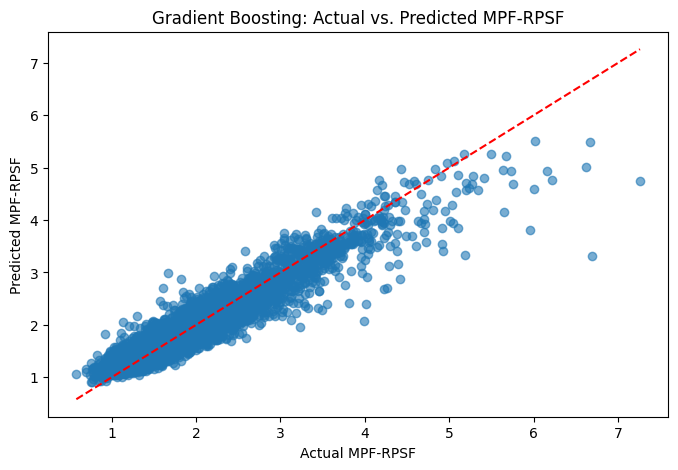

In [53]:
plt.figure(figsize=(8,5))
plt.scatter(y_rent_test_reg_2, y_pred_gbr, alpha=0.6)
plt.xlabel('Actual MPF-RPSF')
plt.ylabel('Predicted MPF-RPSF')
plt.title('Gradient Boosting: Actual vs. Predicted MPF-RPSF')
plt.plot([y_rent_test_reg_2.min(), y_rent_test_reg_2.max()], [y_rent_test_reg_2.min(), y_rent_test_reg_2.max()], color='red', linestyle='--')
plt.show()

***Feedforward Neural Network***

In [54]:
#change preprocessor to make the onehotencoding sparse because neural networks needs sparse values for columns thatr are encoded
preprocessor_rent_nn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_rent_reg_2),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse=False), categorical_features_rent_reg_2)
    ]
)

In [55]:
X_train_nn_transformed = preprocessor_rent_nn.fit_transform(X_rent_train_reg_2)
X_test_nn_transformed = preprocessor_rent_nn.transform(X_rent_test_reg_2)

c:\Users\ahmad\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [56]:
#developing FFNN architecture
input_dim = X_train_nn_transformed.shape[1]
model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_dim=input_dim))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1))

In [74]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                12032     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14657 (57.25 KB)
Trainable params: 14657 (57.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [66]:
model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [67]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [68]:
history_nn = model_nn.fit(
    X_train_nn_transformed, y_rent_train_reg_2,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
665/665 [==============================] - 1s 983us/step - loss: 0.2634 - mean_squared_error: 0.2634 - val_loss: 0.0528 - val_mean_squared_error: 0.0528
Epoch 2/10
665/665 [==============================] - 1s 819us/step - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 3/10
665/665 [==============================] - 1s 833us/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 4/10
665/665 [==============================] - 1s 819us/step - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 5/10
665/665 [==============================] - 1s 801us/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0368 - val_mean_squared_error: 0.0368
Epoch 6/10
665/665 [==============================] - 1s 813us/step - loss: 0.0364 - mean_squared_error: 0.0364 - val_loss: 0.0379 - val_mean_squared_error: 0.0379
Epoch 7/10
665/6

In [69]:
test_loss, test_mse = model_nn.evaluate(X_test_nn_transformed, y_rent_test_reg_2)
print(f"Neural Network Test MSE: {test_mse:.2f}")

208/208 [==============================] - 0s 606us/step - loss: 0.0349 - mean_squared_error: 0.0349
Neural Network Test MSE: 0.03


In [70]:
y_pred_nn = model_nn.predict(X_test_nn_transformed).flatten()
nn_mse = mean_squared_error(y_rent_test_reg_2, y_pred_nn)
nn_r2 = r2_score(y_rent_test_reg_2, y_pred_nn)


208/208 [==============================] - 0s 515us/step


In [71]:
print(f'FFNN MSE: {nn_mse}')
print(f'FFNN R-squared: {nn_r2}')

FFNN MSE: 0.03491363778280157
FFNN R-squared: 0.9321020479792688


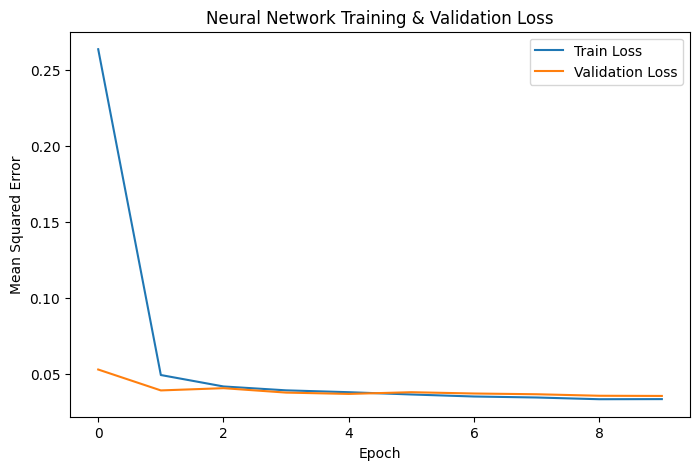

In [72]:
plt.figure(figsize=(8,5))
plt.plot(history_nn.history['loss'], label='Train Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Neural Network Training & Validation Loss')
plt.legend()
plt.show()

# Model Results

| **Model**              | **Mean Squared Error (MSE)** | **R² Score** | **Cross-Validated MSE** | **Model Used**  |
|------------------------|------------------------------|--------------|-------------------------|-----------------|
| **Model 3 (Baseline RF)**  | 0.04040                         | 0.9214         | Random Forest baseline using features including *market_share*                                                                                         |  Random Forest Regressor |
| **Gradient Boosting**  | 0.06                         | 0.89         | Ensemble method that captures non-linear relationships. Feature importance shows *market_share* as influential.                                          |  Gradient Boosting Regressor |
| **Neural Network**     | 0.03836                         |  0.9254        | Feed-forward NN with 3 hidden layers (64, 32, 16 neurons). Uses ReLU activations and early stopping; learns complex interactions with *market_share*. | Feed-forward Neural Network (Architecure shown above) |


# Simulation of Predicted Prices Based on Varying Inputs

In this section, we perform simulations to illustrate how the predicted price per square foot (MPF-RPSF) changes as key input features vary. We focus on two cases:

1. **Regressor Model 1 (AKA Model 2) – Varying the `uses_realpage` Flag:**  
   We generate simulated data points for a representative property by holding most features constant while switching the `uses_realpage` flag between 0 and 1. This will help us see the effect of being a RealPage user on the predicted price.

2. **Regressor Model 2 (AKA Model 3) – Varying Market Share and `uses_realpage`:**  
   For the second model, we simulate how the predicted MPF-RPSF changes as RealPage’s market share in the CBSA changes. We generate two sets of simulated properties (one for non-RealPage users and one for RealPage users) while varying the `market_share` feature over a range of values. The resulting plots will show the relationship between market share and predicted price for both groups.

These simulations not only serve to validate the models but also provide clear visual insights that can be presented in our paper and on our website.

In [214]:
# develop simulated data to use for experiment
baseline_avg_sqft = df['averageSquareFootage'].median()
baseline_stories = df['stories'].median()
baseline_cbsa = df['cbsa_code'].mode()[0]
baseline_class = df['class'].mode()[0]
baseline_yearsold = df['yearsold'].median()
baseline_MPF_OCC = df['MPF-OCC'].median()
baseline_unitcount = df['unitcount'].median()

baseline_model1 = {
    'averageSquareFootage': baseline_avg_sqft,
    'stories': baseline_stories,
    'cbsa_code': baseline_cbsa,
    'class': baseline_class,
    'yearsold': baseline_yearsold,
    'MPF-OCC': baseline_MPF_OCC,
    'unitcount': baseline_unitcount,
}

In [215]:
sim_data_model1 = pd.DataFrame([
    {**baseline_model1, 'uses_realpage': 0},
    {**baseline_model1, 'uses_realpage': 1}
])

In [216]:
preds_model1 = reg_pipeline.predict(sim_data_model1)
sim_data_model1['Predicted_RPSF'] = preds_model1

In [217]:
print("Model 1 Simulation Data:")
print(sim_data_model1)

Model 1 Simulation Data:
   averageSquareFootage  stories  cbsa_code class  yearsold  MPF-OCC  \
0                 902.0      3.0      26420     B      31.0    0.955   
1                 902.0      3.0      26420     B      31.0    0.955   

   unitcount  uses_realpage  Predicted_RPSF  
0      204.0              0         1.48282  
1      204.0              1         1.50443  


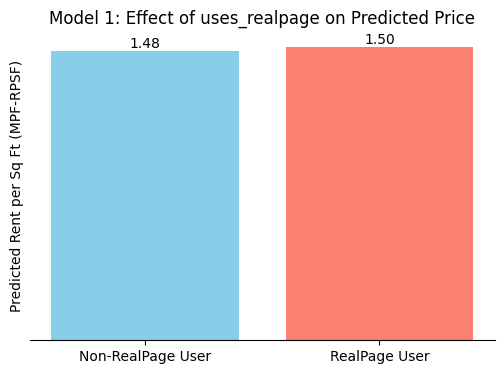

In [220]:
plt.figure(figsize=(6,4))
bars = plt.bar(['Non-RealPage User', 'RealPage User'], preds_model1, color=['skyblue', 'salmon'])

plt.ylabel('Predicted Rent per Sq Ft (MPF-RPSF)')
plt.title('Model 1: Effect of uses_realpage on Predicted Price')

# Add data labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

ax = plt.gca()
# Remove y-axis ticks
ax.set_yticks([])

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

In [228]:
baseline_avg_sqft_2 = model3_df['averageSquareFootage'].median()
baseline_stories_2 = model3_df['stories'].median()
baseline_cbsa_2 = model3_df['cbsa_code'].mode()[0]
baseline_class_2 = model3_df['class'].mode()[0]
baseline_yearsold_2 = model3_df['yearsold'].median()
baseline_MPF_OCC_2 = model3_df['MPF-OCC'].median()
baseline_unitcount_2 = model3_df['unitcount'].median()
market_share_min = model3_df['market_share'].min()
market_share_max = model3_df['market_share'].max()

In [229]:
baseline_model2 = {
    'averageSquareFootage': baseline_avg_sqft_2,
    'stories': baseline_stories_2,
    'cbsa_code': baseline_cbsa_2,
    'class': baseline_class_2,
    'yearsold': baseline_yearsold_2,
    'MPF-OCC': baseline_MPF_OCC_2,
    'unitcount': baseline_unitcount_2,
}

In [230]:
market_shares = np.linspace(market_share_min, market_share_max, 10)

In [231]:
sim_rows = []
for uses in [0, 1]:
    for ms in market_shares:
        sim_row = {**baseline_model2, 'uses_realpage': uses, 'market_share': ms}
        sim_rows.append(sim_row)

In [232]:
sim_data_model2 = pd.DataFrame(sim_rows)

In [233]:
preds_model2 = reg_pipeline_reg_2.predict(sim_data_model2)
sim_data_model2['Predicted_RPSF'] = preds_model2

In [234]:
sim_non_realpage = sim_data_model2[sim_data_model2['uses_realpage'] == 0]
sim_realpage = sim_data_model2[sim_data_model2['uses_realpage'] == 1]

In [73]:
plt.figure(figsize=(8,5))
plt.plot(sim_non_realpage['market_share'], sim_non_realpage['Predicted_RPSF'], marker='o', label='Non-RealPage User', color='skyblue')
plt.plot(sim_realpage['market_share'], sim_realpage['Predicted_RPSF'], marker='o', label='RealPage User', color='salmon')
plt.xlabel('RealPage Market Share in CBSA')
plt.ylabel('Predicted Rent per Sq Ft (MPF-RPSF)')
plt.title('Model 2: Effect of Market Share and uses_realpage on Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'sim_non_realpage' is not defined

<Figure size 800x500 with 0 Axes>

# Simulating distributions of RSPF for Realpage users vs Nonrealpage users

In this section, we perform simulations to illustrate how the distributions of predicted rent per square foot (RSPF) differs between realpage and nonrealpage users using the FFNN model:

- **Variation in RSPF with `uses_realpage` Flag:**  
   We generate simulated data points for a representative property by holding most features constant while switching the `uses_realpage` flag between 0 and 1. This will help us see the effect of being a RealPage user on the predicted price.

1. **Varying `market_share` and `uses_realpage`:**  
   The second simulation will show how the predicted MPF-RPSF changes as RealPage’s market share in the CBSA changes. We generate two sets of simulated properties (one for non-RealPage users and one for RealPage users) while varying the `market_share` feature over a range of values. The resulting plots will show the relationship between market share and predicted price for both groups.

Our goal will be to show that the distributions of the predictions will differ greatly as the variable of uses_realpage changes.

In [76]:
sim_data = pd.read_csv('simulated_50_properties.csv')

In [78]:
sim_data_realpage = sim_data.copy()
sim_data_nonrealpage = sim_data.copy()

In [79]:
sim_data_realpage['uses_realpage'] = 1
sim_data_nonrealpage['uses_realpage'] = 0

In [80]:
sim_data_realpage

,averageSquareFootage,stories,cbsa_code,class,yearsold,MPF-OCC,unitcount,uses_realpage,market_share
0,1010.0,5.0,48060,B,1.0,0.96,274.0,1,0.03
1,882.0,2.2,41060,B,22.0,0.96,304.0,1,0.21
2,1040.0,1.0,15980,A,24.0,0.92,379.0,1,0.31
3,1217.0,6.2,38060,B,14.0,0.96,375.0,1,0.22
4,863.0,7.9,11260,C,28.0,0.96,22.0,1,0.01
5,863.0,7.5,16700,B,40.0,0.92,86.0,1,0.09
6,1228.0,0.3,46520,A,72.0,1.00,297.0,1,0.24
7,1065.0,2.5,47260,B,35.0,0.97,297.0,1,0.07
8,816.0,5.0,29020,A,37.0,0.90,297.0,1,0.17
9,1019.0,7.6,40900,A,30.0,0.97,781.0,1,0.20


In [83]:
sim_data_nonrealpage.columns

Index(['averageSquareFootage', 'stories', 'cbsa_code', 'class', 'yearsold',
       'MPF-OCC', 'unitcount', 'uses_realpage', 'market_share'],
      dtype='object')

In [82]:
features_rent_reg_2

['averageSquareFootage',
 'stories',
 'cbsa_code',
 'class',
 'yearsold',
 'MPF-OCC',
 'unitcount',
 'uses_realpage',
 'market_share']

In [84]:
X_sim_rp = preprocessor_rent_nn.transform(sim_data_realpage[features_rent_reg_2])
X_sim_nonrp = preprocessor_rent_nn.transform(sim_data_nonrealpage[features_rent_reg_2])

In [85]:
preds_sim_rp = model_nn.predict(X_sim_rp).flatten()
preds_sim_nonrp = model_nn.predict(X_sim_nonrp).flatten()

2/2 [==============================] - 0s 1ms/step


In [87]:
sim_data_realpage['Predicted_RPSF'] = preds_sim_rp
sim_data_nonrealpage['Predicted_RPSF'] = preds_sim_nonrp

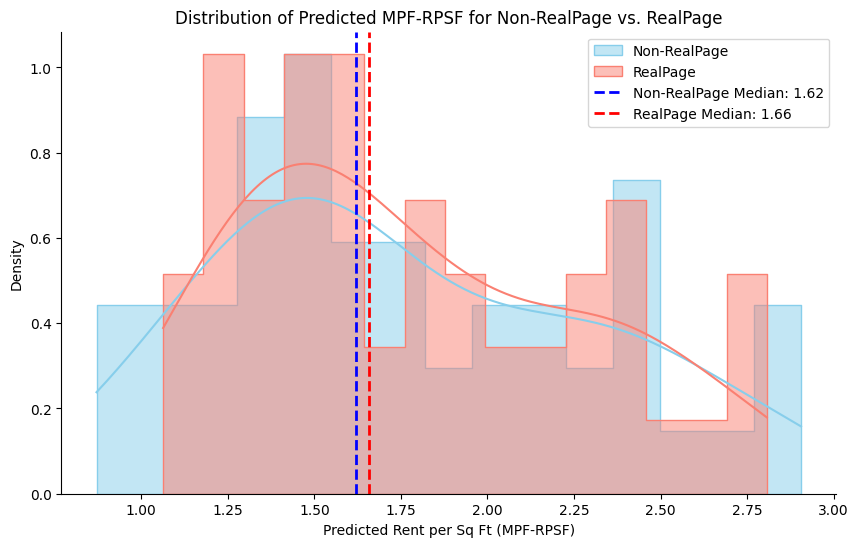

In [97]:
median_nonrp = np.median(preds_sim_nonrp)
median_rp    = np.median(preds_sim_rp)

plt.figure(figsize=(10,6))

sns.histplot(preds_sim_nonrp, label="Non-RealPage", color="skyblue", kde=True, bins=15, stat="density", element="step")
sns.histplot(preds_sim_rp, label="RealPage", color="salmon", kde=True, bins=15, stat="density", element="step")

plt.axvline(median_nonrp, color="blue", linestyle="--", linewidth=2, label=f"Non-RealPage Median: {median_nonrp:.2f}")
plt.axvline(median_rp, color="red", linestyle="--", linewidth=2, label=f"RealPage Median: {median_rp:.2f}")

plt.xlabel("Predicted Rent per Sq Ft (MPF-RPSF)")
plt.ylabel("Density")
plt.title("Distribution of Predicted MPF-RPSF for Non-RealPage vs. RealPage")
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


In [101]:
u_stat, u_p_value = stats.mannwhitneyu(preds_sim_rp, preds_sim_nonrp, alternative='greater')

print("One-sided Mann–Whitney U test (RealPage > Non-RealPage):")
print(f"U-statistic: {u_stat:.4f}")
print(f"p-value: {u_p_value:.4f}")

One-sided Mann–Whitney U test (RealPage > Non-RealPage):
U-statistic: 1270.0000
p-value: 0.4465


In [102]:
alpha = 0.05
if u_p_value < alpha:
    print("\nResult: The predicted MPF-RPSF for RealPage properties is significantly higher than for Non-RealPage properties (p < 0.05).")
else:
    print("\nResult: The test did not detect a statistically significant difference (p >= 0.05).")


Result: The test did not detect a statistically significant difference (p >= 0.05).
